In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
#os.environ['XLA_FLAGS'] = "--xla_force_host_platform_device_count=8"
import jax
#jax.config.update("jax_platform_name", "cpu")

from jax import numpy as jnp
from jax.experimental import host_callback
from flax import struct
from flax.core import frozen_dict

from tqdm.auto import tqdm
from functools import partial
import optax
import matplotlib.pyplot as plt

In [2]:
jax.devices()

[cuda(id=0)]

In [3]:
import frozen_lake
import utils
import qlearning
import plotting

In [4]:
seed = 42
map_size = 8

# hyperparams
lr = 1e-3
n_rollouts = 100
rollout_length = 256
train_iter = 8
eps_annealing = optax.cosine_decay_schedule(1.0, train_iter * n_rollouts, 0.01)

# setup
env = frozen_lake.FrozenLake((map_size, map_size))
qnet = utils.ConvNet(hidden=[2 * map_size] * int(jnp.log2(map_size)), out=4)
rollout = utils.get_rollout_fn(env, utils.eps_greedy_policy(qnet.apply))

In [25]:
def initialize_env(rng_key: jax.Array):
    rng_env_init, rng_env_reset = jax.random.split(rng_key)
    env_params = env.init(rng_env_init)
    env_state, env_obs = env.reset(env_params, rng_env_reset)
    return env_params, env_obs


def initialize_train_state(rng_key: jax.Array, env_obs: frozen_lake.ObsType):
    qnet_params = qnet.init(rng_key, env_obs)
    train_state = qlearning.DDQNTrainState.create(
        apply_fn=qnet.apply, params=qnet_params, tx=optax.adam(lr)
    )
    return train_state


def run_sim(rng_key: jax.Array):
    rng_env_init, rng_ts_init, rng_loop = jax.random.split(rng_key, 3)

    env_params, env_obs = initialize_env(rng_env_init)
    train_state = initialize_train_state(rng_ts_init, env_obs)

    def loop_body(train_state, rng_key):
        # bind progress bar update host callback to rng_key split
        rng_expl, rng_eval = host_callback.id_tap(
            lambda a, t: pbar.update(1), jax.random.split(rng_key)
        )

        # exploration rollout
        transitions = rollout(
            env_params,
            train_state.params,
            rng_key=rng_expl,
            epsilon=eps_annealing(train_state.step),
            n_steps=rollout_length,
        )

        # policy training
        for _ in range(train_iter):
            grads = train_state.td_gradient(transitions)
            train_state = train_state.apply_updates(grads)

        # evaluation rollout
        eval_transitions = rollout(
            env_params,
            train_state.params,
            rng_key=rng_eval,
            epsilon=0.0,
            n_steps=rollout_length,
        )
        return train_state, (eval_transitions.reward, eval_transitions.done)

    pbar = tqdm(total=n_rollouts)
    train_state, eval = jax.lax.scan(loop_body, train_state, jax.random.split(rng_loop, n_rollouts))
    pbar.close()
    return train_state, eval

In [26]:
rng_key = jax.random.PRNGKey(seed)
train_state, eval_trans = jax.vmap(run_sim)(jax.random.split(rng_key, 8))

  0%|          | 0/100 [00:00<?, ?it/s]

In [27]:
rewards, done = eval_trans

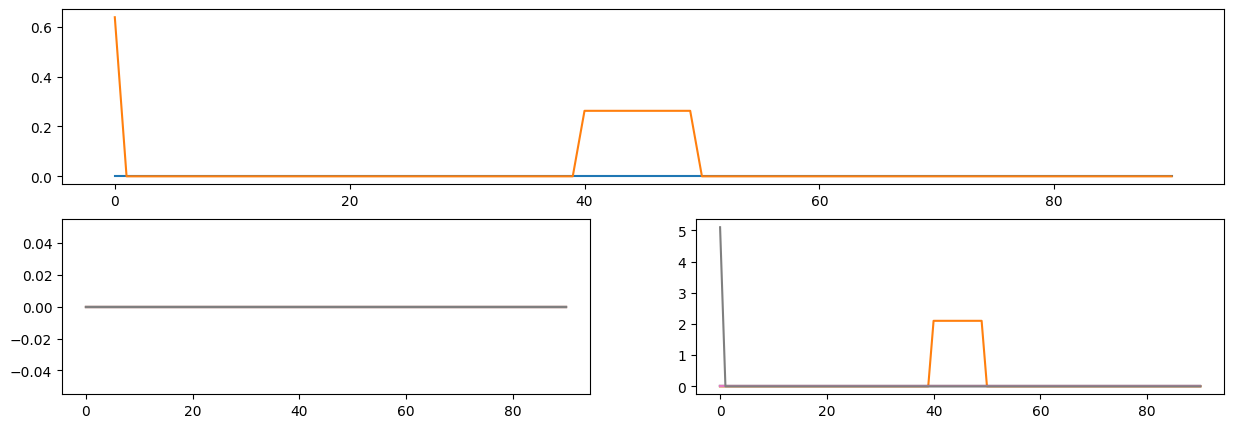

In [28]:
def smooth(r):
    return jnp.convolve(r, jnp.ones(10) / 10, mode="valid")

plt.figure(figsize=(15, 5))
plt.subplot(211)
plt.plot(smooth(rewards.sum(axis=-1).mean(axis=0)), label="reward") 
plt.plot(smooth(done.sum(axis=-1).mean(axis=0)), label="done")
for r, n in zip(rewards.sum(axis=-1), done.sum(axis=-1)):
    plt.subplot(223)
    plt.plot(smooth(r))
    plt.subplot(224)
    plt.plot(smooth(n))

No success


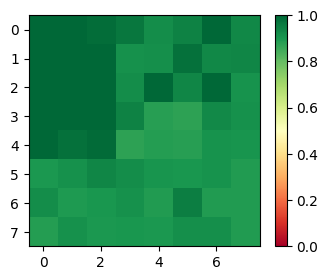

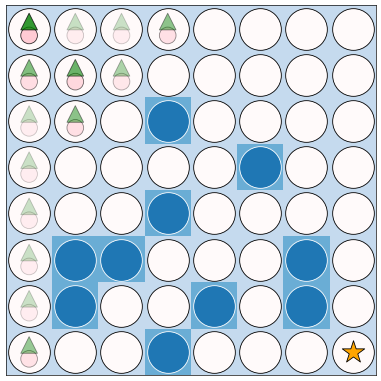

In [29]:
env_params, env_obs = initialize_env(rng_key)
get_qval = lambda p, o: jax.vmap(qnet.apply, in_axes=(0, None))(p, o).mean(axis=0)

batch_rollout = jax.vmap(partial(rollout, env_params, rng_key=rng_key, epsilon=0.0, n_steps=30))
transitions = batch_rollout(train_state.params)
transitions = jax.tree_map(lambda x: x.reshape(-1, *x.shape[2:]), transitions)

plotting.plot_qvals(env, env_params, get_qval, train_state.params)
plotting.render(transitions.env_state, env_params)
if transitions.done.sum() > 0:
    print(f"{int(100*transitions.reward.sum()/transitions.done.sum())}%")
else:
    print("No success")